Here we'll put the bulk of the work.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

v_df = pd.read_csv(
    'datasets/visits_log_us.csv',
    parse_dates=['start_time', 'end_time'],
    dtype=
        {
            'device': 'category',
            'source_id': 'category'
        }
    )
o_df = pd.read_csv(
    'datasets/orders_log_us.csv',
    parse_dates=['purchase_time']
)
c_df = pd.read_csv(
    'datasets/costs_us.csv',
    parse_dates=['date'],
    dtype=
        {
            'source_id': 'category'
        }
)

# for checking on the data, but only one line needs to be commented out or un-commented out
check_data = False
# check_data = True
if check_data:
    v_df.info()
    print(v_df.head())
    print()
    o_df.info()
    print(o_df.head())
    print()
    c_df.info()
    print(c_df.head())

In [2]:
v_df['session_year']  = v_df['start_time'].dt.isocalendar().year
v_df['session_month'] = v_df['start_time'].dt.month
v_df['session_week']  = v_df['start_time'].dt.isocalendar().week
v_df['session_date'] = v_df['start_time'].dt.date

print(v_df.sample(7))

         device            end_time source_id          start_time  \
298625  desktop 2018-05-10 08:52:00         5 2018-05-10 08:32:00   
10387     touch 2018-03-03 00:37:00         4 2018-03-03 00:17:00   
205002  desktop 2017-08-22 20:18:00         3 2017-08-22 20:16:00   
31195   desktop 2017-11-16 14:19:00         3 2017-11-16 14:18:00   
268517  desktop 2017-07-03 09:46:00         3 2017-07-03 09:34:00   
230407  desktop 2017-08-16 14:29:00         2 2017-08-16 14:29:00   
159913  desktop 2018-02-07 10:12:00         5 2018-02-07 10:09:00   

                         uid  session_year  session_month  session_week  \
298625  12578373756585528023          2018              5            19   
10387   15276917599229763099          2018              3             9   
205002  11756354299278196232          2017              8            34   
31195    2054629551274045430          2017             11            46   
268517  13230327258907599999          2017              7            27 

In [3]:
dau_total = (
    v_df.groupby('session_date')
    .agg({'uid': 'nunique'})
    .mean()
)

wau_total = (
    v_df.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    .mean()
)

mau_total = (
    v_df.groupby(['session_year', 'session_month'])
    .agg({'uid': 'nunique'})
    .mean()
)

sticky_wau = (dau_total / wau_total) * 100
sticky_mau = (dau_total / mau_total) * 100

print(f'dau = {int(dau_total)} wau = {int(wau_total)} mau = {int(mau_total)}')
print(f'sticky_wau = {float(sticky_wau):.2f}% sticky_mau = {float(sticky_mau):.2f}%')

dau = 907 wau = 5716 mau = 23228
sticky_wau = 15.88% sticky_mau = 3.91%


In [4]:
v_df['session_duration_mins'] = (
    v_df['end_time'] - v_df['start_time']
).dt.seconds / 60

v_df[['uid', 'start_time', 'session_duration_mins']].sample(10)

,uid,start_time,session_duration_mins
185448,5311353913839527008,2018-04-12 10:39:00,1.0
158850,6778725849774693207,2017-12-29 20:26:00,14.0
101599,5007457502133111979,2017-12-17 23:46:00,8.0
72893,9446814858677088609,2017-07-20 01:26:00,2.0
110739,2828163728594928340,2018-04-03 13:26:00,1.0
171249,11616947936617491261,2018-02-06 12:12:00,16.0
266651,870787085649045326,2017-10-08 02:46:00,1.0
105199,12975000853756992294,2018-05-08 14:11:00,0.0
235822,12869801667763685675,2018-01-17 18:10:00,5.0
39148,13060459396467648326,2017-08-28 20:18:00,4.0


In [5]:
v_by_day = v_df.groupby('session_date').agg({
    'start_time': 'count'
})
v_by_day = v_by_day.rename(
    columns={
        'start_time': 'sessions'
    }
)
v_by_day.sample(10)

,sessions
session_date,
2018-05-04,799
2018-03-18,773
2018-04-21,838
2017-11-01,1339
2018-01-21,1017
2017-08-02,379
2018-01-22,1399
2017-06-23,473
2018-05-11,879


In [6]:
first_session_date = v_df.groupby(['uid'])['session_date'].min()
first_session_date.name = 'first_session_date'

v_df = v_df.join(first_session_date, on='uid')

In [7]:
first_session_week = v_df.groupby(['uid'])['session_week'].min()
first_session_week.name = 'first_session_week'

v_df = v_df.join(first_session_week, on='uid')

In [8]:
first_session_month = v_df.groupby(['uid'])['session_month'].min()
first_session_month.name = 'first_session_month'

v_df = v_df.join(first_session_month, on='uid')

In [9]:
v_df['cohort_lifetime_months'] = ((
        v_df['session_date']
            -
        v_df['first_session_date']
    ) / np.timedelta64(1, 'M')
).astype(int)
v_df['cohort_lifetime_weeks'] = ((
        v_df['session_date']
            -
        v_df['first_session_date']
    ) / np.timedelta64(1, 'W')
).astype(int)
v_df['cohort_lifetime_days'] = ((
        v_df['session_date']
            -
        v_df['first_session_date']
    ) / np.timedelta64(1, 'D')
).astype(int)

v_df[['uid', 'cohort_lifetime_days', 'cohort_lifetime_weeks', 'cohort_lifetime_months']].sample(10)

,uid,cohort_lifetime_days,cohort_lifetime_weeks,cohort_lifetime_months
72338,7462209185171040152,0,0,0
325280,11455897332515568981,0,0,0
57967,1782245918922009041,161,23,5
22575,15286091144986615617,0,0,0
270849,18248677799034000505,0,0,0
341958,6802989016689107627,0,0,0
145107,10132944959333537230,0,0,0
53451,15026711963927702084,0,0,0
101468,8316976270858647025,0,0,0
334820,10050897247062126207,173,24,5


In [45]:
cohorts_weekly = (
    v_df.groupby(['first_session_week', 'cohort_lifetime_weeks'])
    .agg({'uid': 'nunique'})
    .reset_index()
)

initial_users_count = cohorts_weekly[cohorts_weekly['cohort_lifetime_weeks'] == 0][ ['first_session_week', 'uid'] ]
initial_users_count = initial_users_count.rename(
    columns={'uid': 'weekly_cohort_users'}
) 

cohorts_weekly = cohorts_weekly.merge(initial_users_count, on='first_session_week')

,first_session_week,cohort_lifetime_weeks,uid,weekly_cohort_users
0,1,0,6918,6918
1,1,1,445,6918
2,1,2,364,6918
3,1,3,352,6918
4,1,4,343,6918
...,...,...,...,...
1599,50,1,105,5107
1600,50,2,41,5107
1601,51,0,4617,4617
1602,51,1,51,4617


In [10]:
cohorts_monthly = (
    v_df.groupby(['first_session_month', 'cohort_lifetime_months'])
    .agg({'uid': 'nunique'})
    .reset_index()
)

initial_users_count = cohorts_monthly[cohorts_monthly['cohort_lifetime_months'] == 0][ ['first_session_month', 'uid'] ]
initial_users_count = initial_users_count.rename(
    columns={'uid': 'monthly_cohort_users'}
) 

cohorts_monthly = cohorts_monthly.merge(initial_users_count, on='first_session_month')

cohorts_monthly['retention'] = cohorts_monthly['uid'] / cohorts_monthly['monthly_cohort_users']

cohorts_monthly[['first_session_month', 'monthly_cohort_users', 'retention']].sample(10)

,first_session_month,monthly_cohort_users,retention
6,1,28716,0.043634
73,7,11450,0.000087
25,3,23510,0.041684
55,5,16834,0.015386
37,4,17468,0.028681
40,4,17468,0.026219
18,2,26007,0.022186
52,5,16834,0.011287
79,9,14790,1.000000
58,5,16834,0.011821


In [11]:
# make and print table
retention_pivot = cohorts_monthly.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime_months',
    values='retention',
    aggfunc='sum'
)

retention_pivot.fillna('')

cohort_lifetime_months,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
1,1.0,0.118053,0.098865,0.084343,0.062021,0.048997,0.043634,0.032908,0.017203,0.012746,0.009472,0.006233
2,1.0,0.061945,0.065675,0.051102,0.037913,0.026839,0.022186,0.020841,0.015342,0.004999,0.003538,0.00173
3,1.0,0.041684,0.035006,0.034368,0.03373,0.02769,0.019651,0.014037,0.015355,0.01157,0.003063,0.001148
4,1.0,0.028681,0.006526,0.013453,0.026219,0.024216,0.018892,0.012079,0.008759,0.012938,0.00727,0.001775
5,1.0,0.008554,0.00499,0.004574,0.011287,0.019425,0.018177,0.015386,0.009445,0.007366,0.011821,0.009029
6,1.0,0.034397,0.032187,0.038288,0.034928,0.033336,0.018216,,,,,
7,1.0,0.035284,0.03607,0.033188,0.033362,0.014847,0.000087,,,,,
8,1.0,0.043823,0.041923,0.034097,0.013639,,,,,,,
9,1.0,0.051454,0.043475,0.012711,,,,,,,,


In [12]:
first_purchase_date = o_df.groupby(['uid'])['purchase_time'].min()
first_purchase_date.name = 'first_purchase_date'

user_conversion = (
    first_session_date.to_frame()
    .join(first_purchase_date, on='uid')
    .dropna()
    # .fillna('never')
)
user_conversion.reset_index(inplace=True)
user_conversion['conversion_days'] = ((
        user_conversion['first_purchase_date']
            -
        pd.to_datetime(user_conversion['first_session_date'])
    ) / np.timedelta64(1, 'D')
).astype(int)

user_conversion.sample(10)

,uid,first_session_date,first_purchase_date,conversion_days
6084,3076884661339524363,2017-06-27,2017-06-27 10:06:00,0
35762,18043897847555691255,2017-07-05,2017-07-05 13:02:00,0
16212,8132269060137383590,2017-06-13,2018-02-02 20:00:00,234
11869,5953191951006370886,2017-12-04,2017-12-06 15:27:00,2
5632,2852359823334282055,2017-07-04,2017-07-04 22:05:00,0
18277,9252815572717677573,2018-02-21,2018-04-13 21:21:00,51
2575,1328401952991728944,2017-11-08,2017-11-08 11:15:00,0
28463,14360862803291817314,2017-07-30,2017-07-30 16:42:00,0
25002,12625538428871766240,2017-11-14,2017-11-14 00:38:00,0
22165,11194279856475206824,2017-10-09,2017-10-09 21:19:00,0


In [13]:
user_conversion['conversion_days'].value_counts()

0      25039
1       1966
2        685
3        452
4        386
       ...  
343        1
282        1
318        1
353        1
358        1
Name: conversion_days, Length: 349, dtype: int64

In [14]:
v_df[[
    'uid', 
    'cohort_lifetime_months', 
    'cohort_lifetime_weeks', 
    'cohort_lifetime_days'
]].sample(10)

,uid,cohort_lifetime_months,cohort_lifetime_weeks,cohort_lifetime_days
141271,9798551198744761879,0,0,0
22864,969393490514376282,0,0,2
263672,1939433599773301236,0,0,0
290462,16220501150407758376,0,3,21
330224,5117964040515222798,0,0,0
164375,1429719929952592122,0,1,8
45684,18198642943550411214,0,0,0
115706,11446857734615384463,0,0,0
25642,18391778818283951311,0,0,0
275284,17786796508613183016,4,21,150


In [15]:
o_df = o_df.merge(user_conversion[['uid', 'first_purchase_date']], on='uid', how='left')

# o_df.head()

In [16]:
o_df['user_age'] = ((
        o_df['purchase_time']
            -
        o_df['first_purchase_date']
    ) / np.timedelta64(1, 'D')
)

# o_df.sample(10)

In [17]:
# Group o_df by uid and calculate the total number of purchases per uid
purchase_count = o_df.groupby('uid')['purchase_time'].count()

# Calculate the duration in days, weeks, and months for each uid
duration_days = (o_df.groupby('uid')['purchase_time'].max() - o_df.groupby('uid')['purchase_time'].min()).dt.days
duration_weeks = duration_days / 7
duration_months = duration_days / 30

# Calculate the average number of purchases per day, week, and month
avg_purchases_per_day = np.where(duration_days == 0, 0, purchase_count / duration_days)
avg_purchases_per_week = np.where(duration_weeks == 0, 0, purchase_count / duration_weeks)
avg_purchases_per_month = np.where(duration_months == 0, 0, purchase_count / duration_months)

# Combine the results into a new DataFrame
average_purchases_df = pd.DataFrame({
    'uid': purchase_count.index,
    'avg_purchases_per_day': avg_purchases_per_day,
    'avg_purchases_per_week': avg_purchases_per_week,
    'avg_purchases_per_month': avg_purchases_per_month
})

# Display the average purchases per day, week, and month
# average_purchases_df.sample(20)


In [18]:
# Group o_df by uid and calculate the total profit and number of purchases per uid
purchase_stats = o_df.groupby('uid').agg({'profit': 'sum', 'purchase_time': 'count'})

# Calculate the average purchase size per user
average_purchase_size_per_user = purchase_stats['profit'] / purchase_stats['purchase_time']

# Add the average purchase size per user to o_df
o_df = o_df.merge(average_purchase_size_per_user.rename('average_purchase_size_per_user'), on='uid')

# Display the average purchase size per user
average_purchase_size_per_user_df = o_df[['uid', 'average_purchase_size_per_user']].drop_duplicates()
# average_purchase_size_per_user_df.sample(10)


In [19]:
total_ltv_data = o_df.groupby('uid')['profit'].sum().reset_index()

total_ltv_data = total_ltv_data.sort_values('profit', ascending=False)

total_ltv_data.head(20)


,uid,profit
11014,5539673724080479777,11810.18
22073,11149926373378902217,10519.46
35670,17999372575896145244,1979.33
13459,6731421022966725351,1450.68
7206,3644482766749211722,1444.29
19248,9737640335185488211,1310.71
16979,8539015707073391293,1240.76
27482,13888745432979765063,1191.02
3276,1668300487562478408,1163.63
12541,6268225112727843212,1158.32


In [20]:
purchase_stats = o_df.groupby('uid').agg({'profit': 'sum', 'purchase_time': 'count'})

purchase_stats.sample(20)

average_purchase_size = purchase_stats['profit'] / purchase_stats['purchase_time']

# print(average_purchase_size)


In [21]:
total_costs = c_df.agg({'costs': 'sum'})
total_costs

costs    329131.62
dtype: float64

In [22]:
sourcely_costs = c_df.groupby('source_id').agg({'costs':'sum'}).reset_index()

# sourcely_costs

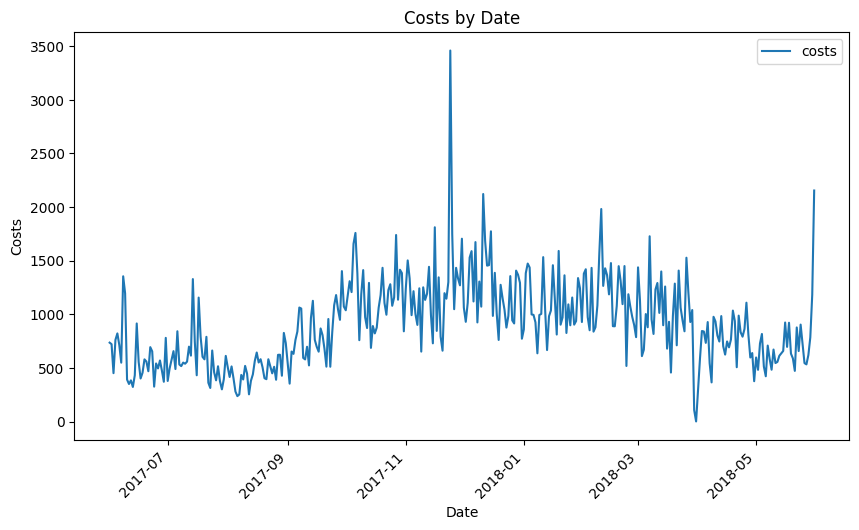

In [23]:
daily_costs = c_df.groupby('date').agg({'costs': 'sum'})

# Create the plot using Pandas plot()
daily_costs.plot(figsize=(10, 6))

# Customize the plot
plt.title('Costs by Date')
plt.xlabel('Date')
plt.ylabel('Costs')
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [24]:
sourcely_users = (
    v_df.groupby(['source_id'])
    .agg({'uid': 'nunique'})
    .reset_index()
)

sourcely_users.columns = ['source_id', 'n_users']

# sourcely_users

In [25]:
cac_report = pd.merge(
    sourcely_costs,
    sourcely_users,
    on='source_id'
)
# cac_report

In [26]:
cac_report['cac'] = cac_report['costs'] / cac_report['n_users']
# cac_report

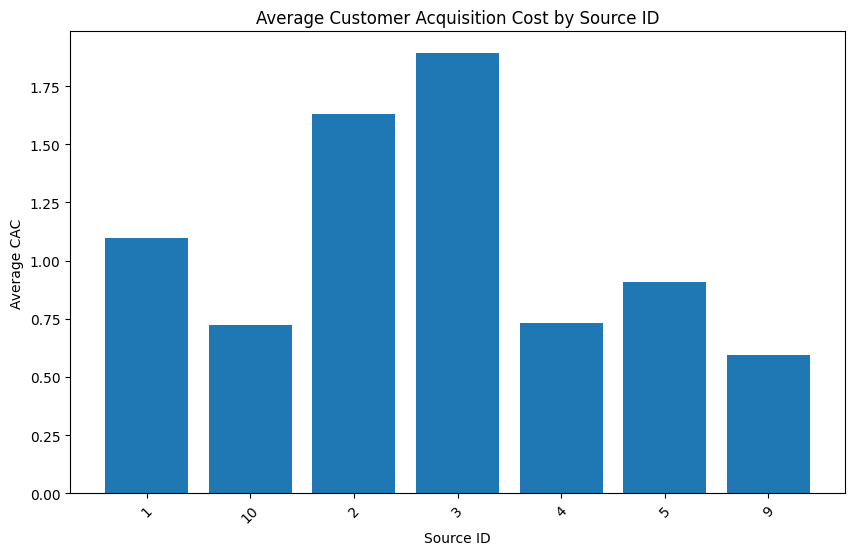

In [27]:
# Plotting the average CAC
plt.figure(figsize=(10, 6))
plt.bar(cac_report['source_id'], cac_report['cac'])
plt.xlabel('Source ID')
plt.ylabel('Average CAC')
plt.title('Average Customer Acquisition Cost by Source ID')
plt.xticks(rotation=45)
plt.show()

In [28]:
avg_ltv_per_user = (
    total_ltv_data.agg({'profit':'mean'})
    .reset_index()
)
avg_ltv_per_user

,index,0
0,profit,6.901328


In [29]:
total_n_users = (
    v_df.agg({'uid': 'nunique'})
    .reset_index()
)
total_n_users

,index,0
0,uid,228169


In [30]:
average_cac_per_user = (total_costs[0] / total_n_users[0]).reset_index()
average_cac_per_user

,index,0
0,0,1.442491


In [31]:
roi = (avg_ltv_per_user[0] / average_cac_per_user[0]).reset_index()

print('roi =', roi[0])

roi = 0    4.784314
Name: 0, dtype: float64


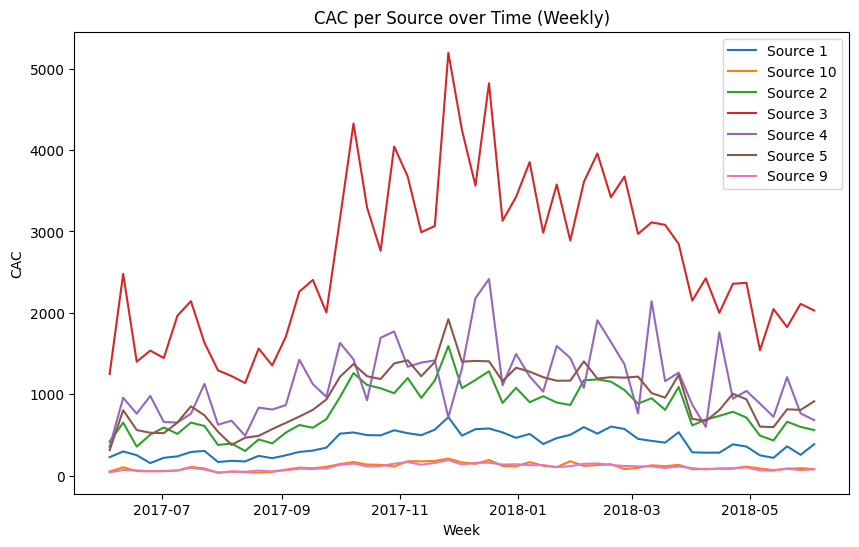

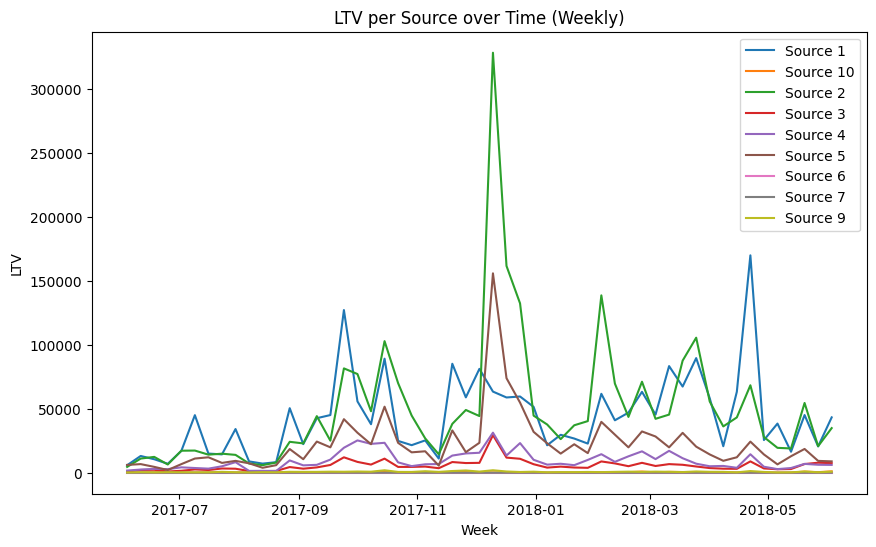

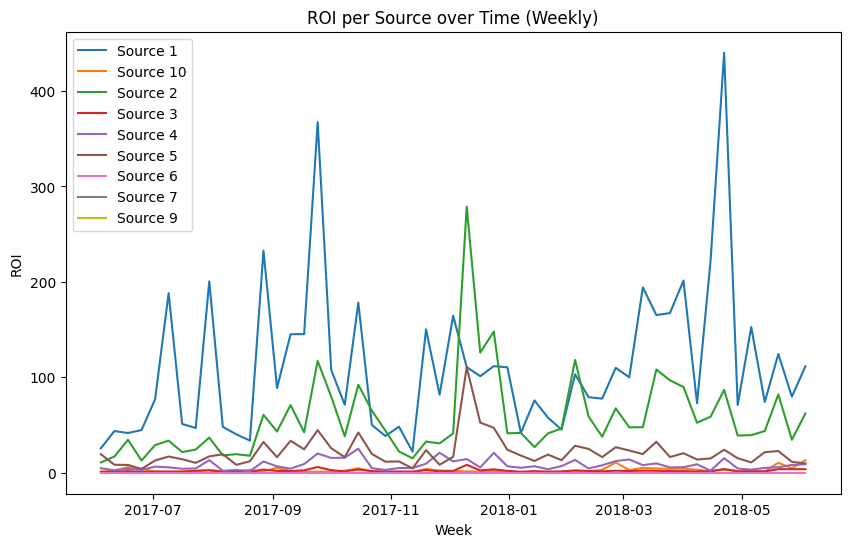

In [37]:
# Graph CAC, LTV, and ROI per device per week

# Calculate CAC per source_id and time period
cac_per_source = c_df.groupby(['source_id', pd.Grouper(key='date', freq='W-SUN')]).agg({'costs': 'sum'}).reset_index()

# Calculate LTV per source_id and time period
# Merge visits and orders tables on 'uid' column
v_and_o_dfs = v_df.merge(o_df, on='uid')

# Group merged dataframe by 'source_id' and week of 'purchase_time', calculate LTV
sourcely_ltv = v_and_o_dfs.groupby(['source_id', pd.Grouper(key='purchase_time', freq='W-SUN')]).agg(
    ltv=('profit', 'sum'),
    unique_users=('uid', 'nunique')
).reset_index()

# Calculate ROI per source_id and time period
roi_per_source = sourcely_ltv.copy()
roi_per_source['roi'] = roi_per_source['ltv'] / cac_per_source['costs']

# Plotting CAC per source_id
plt.figure(figsize=(10, 6))
for source_id, group in cac_per_source.groupby('source_id'):
    plt.plot(group['date'], group['costs'], label=f"Source {source_id}")
plt.xlabel('Week')
plt.ylabel('CAC')
plt.title('CAC per Source over Time (Weekly)')
plt.legend()
plt.show()

# Plotting LTV per source_id
plt.figure(figsize=(10, 6))
for source_id, group in sourcely_ltv.groupby('source_id'):
    plt.plot(group['purchase_time'], group['ltv'], label=f"Source {source_id}")
plt.xlabel('Week')
plt.ylabel('LTV')
plt.title('LTV per Source over Time (Weekly)')
plt.legend()
plt.show()

# Plotting ROI per source_id
plt.figure(figsize=(10, 6))
for source_id, group in roi_per_source.groupby('source_id'):
    plt.plot(group['purchase_time'], group['roi'], label=f"Source {source_id}")
plt.xlabel('Week')
plt.ylabel('ROI')
plt.title('ROI per Source over Time (Weekly)')
plt.legend()
plt.show()


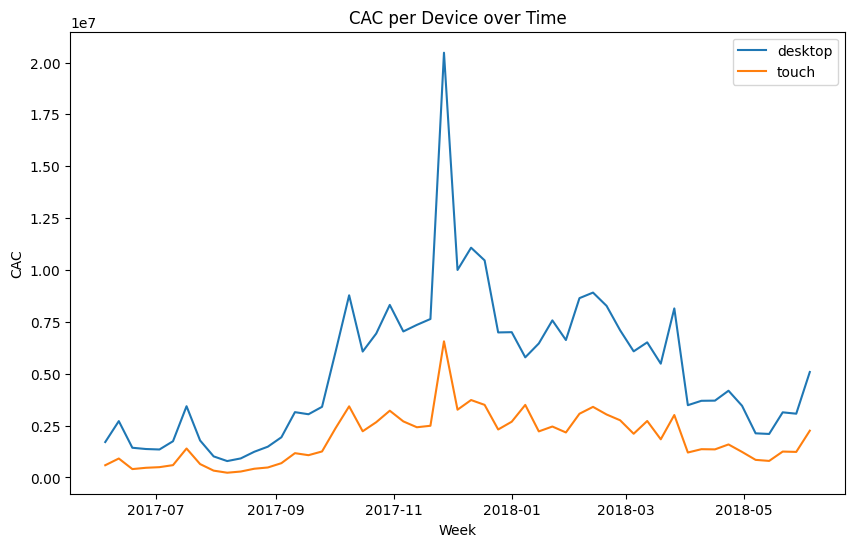

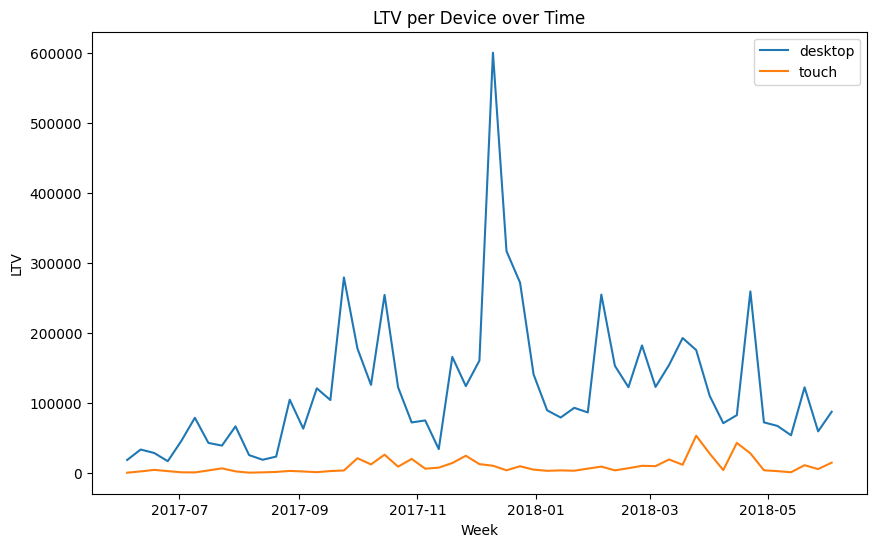

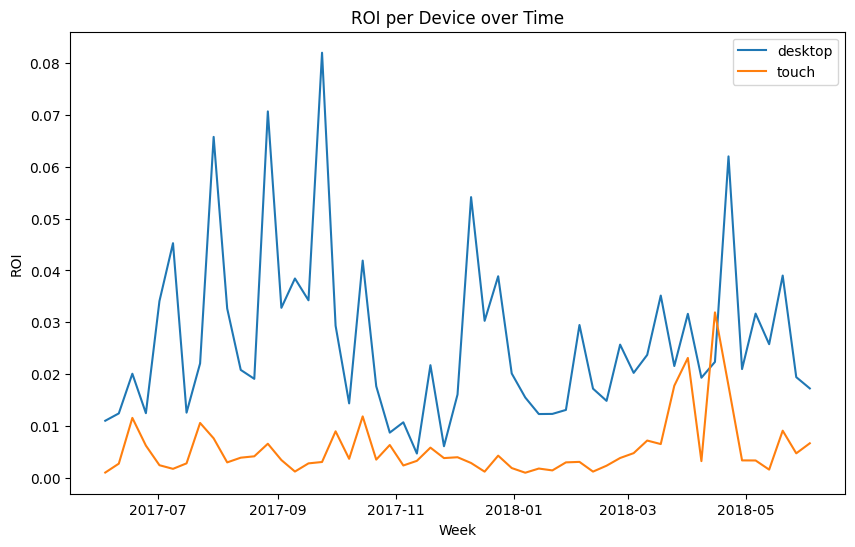

In [40]:
# Graph CAC, LTV, and ROI per device per week

# Extract the date part from the "end_time" column in v_df
v_df['date'] = pd.to_datetime(v_df['end_time'].dt.date)

# Merge v_df and c_df based on the date part
v_and_c_dfs = v_df.merge(c_df, on='date')

# Calculate CAC per device and week
cac_per_device_week = v_and_c_dfs.groupby([v_and_c_dfs['device'], pd.Grouper(key='date', freq='W-MON')])['costs'].sum().reset_index()

# Calculate LTV per device and week

# Calculate LTV per device and week
ltv_per_device_week = v_and_o_dfs.groupby([v_and_o_dfs['device'], pd.Grouper(key='purchase_time', freq='W-SUN')])['profit'].sum().reset_index()

# Calculate ROI per device and week
roi_per_device_week = ltv_per_device_week.copy()
roi_per_device_week['roi'] = roi_per_device_week['profit'] / cac_per_device_week['costs']

# Plotting CAC per device
plt.figure(figsize=(10, 6))
for device, group in cac_per_device_week.groupby('device'):
    plt.plot(group['date'], group['costs'], label=device)
plt.xlabel('Week')
plt.ylabel('CAC')
plt.title('CAC per Device over Time')
plt.legend()
plt.show()

# Plotting LTV per device
plt.figure(figsize=(10, 6))
for device, group in ltv_per_device_week.groupby('device'):
    plt.plot(group['purchase_time'], group['profit'], label=device)
plt.xlabel('Week')
plt.ylabel('LTV')
plt.title('LTV per Device over Time')
plt.legend()
plt.show()

# Plotting ROI per device
plt.figure(figsize=(10, 6))
for device, group in roi_per_device_week.groupby('device'):
    plt.plot(group['purchase_time'], group['roi'], label=device)
plt.xlabel('Week')
plt.ylabel('ROI')
plt.title('ROI per Device over Time')
plt.legend()
plt.show()
